<a href="https://colab.research.google.com/github/omkar-mohanty/3D-Classifier/blob/main/worlflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, initializers
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Current Model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

z_dim = 100  # Latent space dimension

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

class Encoder(layers.Layer):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv3D(30, 3, activation='relu', strides=2, padding='same')
        self.conv2 = layers.Conv3D(60, 3, activation='relu', strides=2, padding='same')
        self.flatten = layers.Flatten()
        self.z_mean = layers.Dense(z_dim)
        self.z_log_var = layers.Dense(z_dim)
        self.z_dim = z_dim

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.flatten(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        z = layers.Lambda(sampling, output_shape=(self.z_dim,), name='z')([z_mean, z_log_var])
        return z_mean, z_log_var, z

class Decoder(layers.Layer):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.dense = layers.Dense(7*7*7*60, activation='relu')
        self.reshape = layers.Reshape((7, 7, 7, 60))
        self.convT1 = layers.Conv3DTranspose(60, 3, activation='relu', strides=2, padding='same')
        self.convT2 = layers.Conv3DTranspose(30, 3, activation='relu', strides=2, padding='same')
        self.convT3 = layers.Conv3DTranspose(1, 3, activation='sigmoid', padding='valid')

    def call(self, inputs):
        x = self.dense(inputs)
        x = self.reshape(x)
        x = self.convT1(x)
        x = self.convT2(x)
        x = self.convT3(x)
        return x

class VAE3D(models.Model):
    def __init__(self, model_input_shape, z_dim):
        super(VAE3D, self).__init__()
        self.encoder = Encoder(z_dim=z_dim)
        self.decoder = Decoder(z_dim=z_dim)
        self.model_input_shape = model_input_shape

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        self.add_loss(self.vae_loss(inputs, reconstructed, z_mean, z_log_var))
        return reconstructed

    def vae_loss(self, inputs, reconstructed, z_mean, z_log_var):
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(inputs - reconstructed), axis=[1, 2, 3]))
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
        return reconstruction_loss + kl_loss

    def encode(self, inputs):
        z_mean, _, _ = self.encoder(inputs)
        return z_mean

# Model instantiation
model_input_shape = (30, 30, 30, 1)
model = VAE3D(model_input_shape=model_input_shape, z_dim=z_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, metrics=['accuracy'])

# Model Training

In [ ]:
import h5py
import numpy as np

# Load dataset (modelnet10)
file_path = '/content/drive/MyDrive/Datasets/3D-Cat/ModelNet10_res30_raw.mat'
data = h5py.File(file_path, 'r')

train_data = np.transpose(data['train'])
test_data = np.transpose(data['test'])

def preprocess_data(data):
    # Extract labels from the first index
    labels = data[:, 0].astype('int32')

    # Remove the ID/label from each entry and reshape the rest into [30, 30, 30, 1]
    voxels = data[:, 1:].reshape((-1, 30, 30, 30, 1)).astype('float32')

    return voxels, labels

train_voxels, train_labels = preprocess_data(train_data)
test_voxels, test_labels = preprocess_data(test_data)


In [ ]:
model.fit(train_voxels, train_voxels, epochs=50, batch_size=200, validation_split=0.1)

Epoch 1/50
18/18 [==============================] - 22s 628ms/step - loss: 4157.8833 - accuracy: 0.8634 - val_loss: 3361.7832 - val_accuracy: 0.8455
Epoch 2/50
18/18 [==============================] - 4s 242ms/step - loss: 2418.4873 - accuracy: 0.8815 - val_loss: 3017.0632 - val_accuracy: 0.8455
Epoch 3/50
18/18 [==============================] - 4s 248ms/step - loss: 2188.9297 - accuracy: 0.8815 - val_loss: 2957.7717 - val_accuracy: 0.8455
Epoch 4/50
18/18 [==============================] - 5s 252ms/step - loss: 2011.7338 - accuracy: 0.8815 - val_loss: 2754.6660 - val_accuracy: 0.8455
Epoch 5/50
18/18 [==============================] - 4s 246ms/step - loss: 1847.3236 - accuracy: 0.8815 - val_loss: 2573.8809 - val_accuracy: 0.8455
Epoch 6/50
18/18 [==============================] - 5s 252ms/step - loss: 1723.9005 - accuracy: 0.8815 - val_loss: 2470.6531 - val_accuracy: 0.8455
Epoch 7/50
18/18 [==============================] - 4s 249ms/step - loss: 1642.5735 - accuracy: 0.8815 - val_lo

In [ ]:
autoencoder_save_path = '/content/drive/MyDrive/Colab Notebooks/models/v5_3Dautoencoder_model'

# Save the autoencoder model
model.save(autoencoder_save_path)

In [ ]:
def extract_features(model, voxels):
    features = model.encode(voxels).numpy()
    return features

train_features = extract_features(model, train_voxels)
test_features = extract_features(model, test_voxels)

In [ ]:
from sklearn.svm import SVC

# Train SVM on extracted features
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(train_features, train_labels)

svm_score = svm_classifier.score(test_features, test_labels)
print(f'SVM Test Accuracy: {svm_score}')

SVM Test Accuracy: 0.8953744493392071


In [ ]:
import joblib

svm_save_path = '/content/drive/MyDrive/Colab Notebooks/models/v5_3DCat_svm_model.joblib'

# Save the SVM model
joblib.dump(svm_classifier, svm_save_path)

['/content/drive/MyDrive/Colab Notebooks/models/v5_3DCat_svm_model.joblib']

# Custom 3D Models

In [ ]:
!pip install git+https://github.com/omkar-mohanty/PyVoxelizer
!pip install git+https://github.com/p-hofmann/MeshReader.git#egg=meshlib
!pip install meshlib>=0.0.2

  Cloning https://github.com/omkar-mohanty/PyVoxelizer to /tmp/pip-req-build-topuxzbh
  Running command git clone --filter=blob:none --quiet https://github.com/omkar-mohanty/PyVoxelizer /tmp/pip-req-build-topuxzbh
  Resolved https://github.com/omkar-mohanty/PyVoxelizer to commit 59c4f47224a46588903657749ea7f818667f58c2
  Preparing metadata (setup.py) ... done
  Created wheel for voxlib: filename=voxlib-0.0.5-py3-none-any.whl size=9577 sha256=7125dd12381e365e6b957963bd0358ec61373de4a65ffc3d8b65b2561aeb744d
  Stored in directory: /tmp/pip-ephem-wheel-cache-50njs3ae/wheels/12/eb/1a/e50e44cc9e3b1b425c7499199b706535ae65ef9abcb0fdf0d0
Successfully built voxlib
  Cloning https://github.com/p-hofmann/MeshReader.git to /tmp/pip-install-0syz2hko/meshlib_a458d51ef32b4248ad22d8b45d061da2
  Running command git clone --filter=blob:none --quiet https://github.com/p-hofmann/MeshReader.git /tmp/pip-install-0syz2hko/meshlib_a458d51ef32b4248ad22d8b45d061da2
  Resolved https://github.com/p-hofmann/MeshRea

In [ ]:
import voxlib.voxelize
import matplotlib.pyplot as plt
import numpy as np

def plot_voxel_grid(matrix):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    matrix = matrix.reshape(matrix.shape[1:4])
    filled = matrix == 1.0  # This assumes that the matrix uses 1.0 for filled voxels
    ax.voxels(filled, facecolors='blue', edgecolor='k')
    plt.show()

def plot_voxel_grid_rotate(matrix, axis='y', k=1):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    matrix = matrix.reshape(matrix.shape[1:4])

    # Rotate the matrix
    if axis == 'z':
        matrix = np.rot90(matrix, k=k, axes=(0, 1))  # Rotate k times around z-axis (y-x plane)
    elif axis == 'x':
        matrix = np.rot90(matrix, k=k, axes=(1, 2))  # Rotate k times around x-axis (z-y plane)
    elif axis == 'y':
        matrix = np.rot90(matrix, k=k, axes=(0, 2))  # Rotate k times around y-axis (z-x plane)

    filled = matrix == 1.0  # This assumes that the matrix uses 1.0 for filled voxels
    ax.voxels(filled, facecolors='blue', edgecolor='k')
    plt.show()

class VoxelModel:
  """
    filename: Must end with .stl
    dim: must be even
  """
  def __init__(self, filename, dim):
    self.mat = normvox(filename, dim)
    self.dim = dim

  def show_3d(self):
    new_voxel = np.expand_dims(np.array(self.mat), axis=(0, -1)).astype('float32')
    plot_voxel_grid_rotate(new_voxel)

"""
Voxelize function outputs (x,y,z) coordinates where the voxel exists, but we need the full dim * dim * dim 3D matrix.
This function initializes a matrix of size dim * dim * dim then fills it up with all zeros first. Then loops over the filled voxel
coordinates and puts 1.0 into them.
"""

def normvox(filename, dim):
    coordinates = voxlib.voxelize.voxelize(filename, dim)

    matrix_size = (dim, dim , dim)
    matrix = [[[0.0 for _ in range(matrix_size[2])] for _ in range(matrix_size[1])] for _ in range(matrix_size[0])]

    for coord in coordinates:

      x, y, z = coord
      "Works for even dimensions only"
      x += int(dim/2) - 1
      y += int(dim/2) - 1
      z += int(dim/2) - 1
      matrix[x][y][z] = 1.0

    return matrix

In [ ]:
import os
import threading

model3d_dir = "/content/drive/MyDrive/3D-Files/selected"

def thread_vox(model_dir: str = model3d_dir):
  lock = threading.Lock()

  threads = []
  models3d = []

  def load_model(filename, dim):
    try:
      model3d = VoxelModel(filename, dim)
      with lock:
        models3d.append(model3d)
    except Exception as e:
      print("Load Error for " + filename + e)

  for file in os.listdir(model_dir):
    if file.endswith(".stl"):
      thread = threading.Thread(target = load_model, args = (model_dir +"/" + file, 30))
      thread.start()
      threads.append(thread)


  for thread in threads:
      thread.join()
  return models3d

In [ ]:
models3d_voxelized = thread_vox()

Voxelize:  |--------------------| 4.9% 
Voxelize:  |====================| 100.0% 
Voxelize:  |====================| 100.0% 
Voxelize:  |====================| 100.0% 
Voxelize:  |====================| 100.0% 
Voxelize:  |====================| 100.0% 
Voxelize:  |====================| 100.0% 
Voxelize:  |====================| 100.0% 


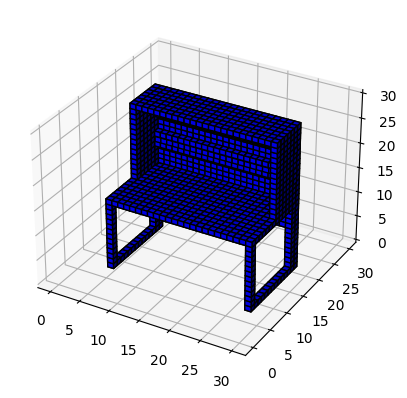

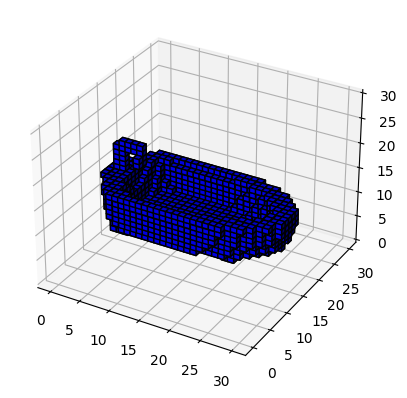

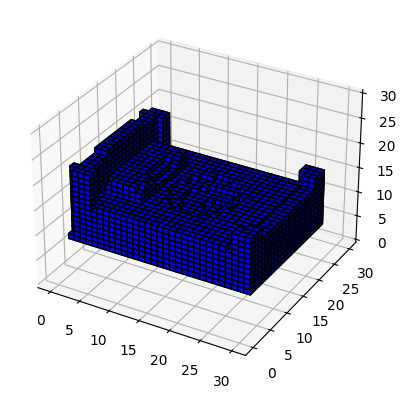

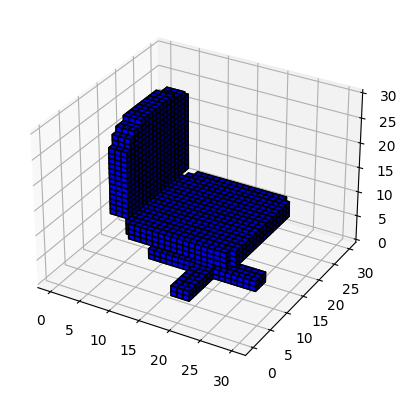

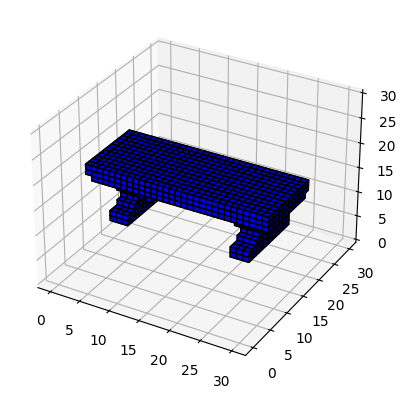

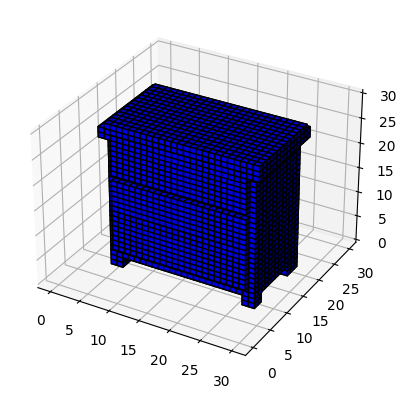

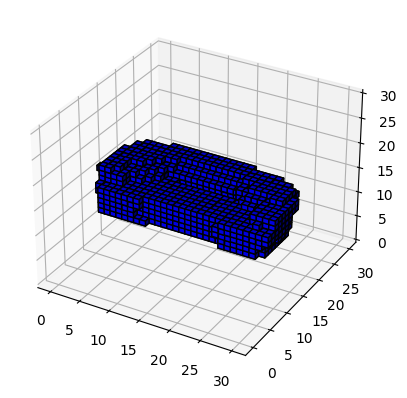

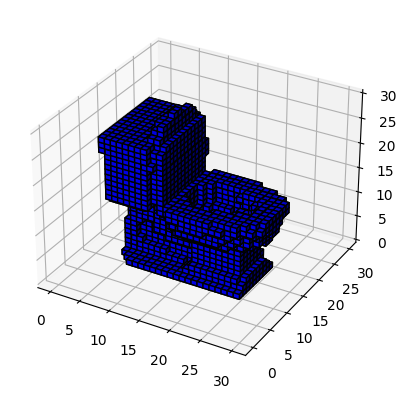

In [ ]:
for model3d_voxelized in models3d_voxelized:
    model3d_voxelized.show_3d()

In [ ]:
import joblib

# Path to the saved models
autoencoder_save_path = '/content/drive/MyDrive/Colab Notebooks/models/v5_3Dautoencoder_model'
svm_save_path = '/content/drive/MyDrive/Colab Notebooks/models/v5_3DCat_svm_model.joblib'

# Load the autoencoder model with custom objects
loaded_autoencoder_model = tf.keras.models.load_model(
    autoencoder_save_path,
    custom_objects={'VAE3D': VAE3D, 'Encoder': Encoder, 'Decoder': Decoder}
)

# Load the SVM model
loaded_svm_classifier = joblib.load(svm_save_path)

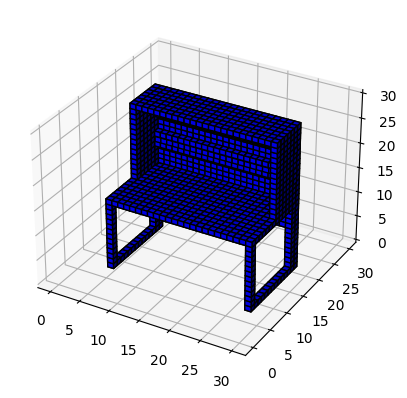

The predicted class for the model is: sofa


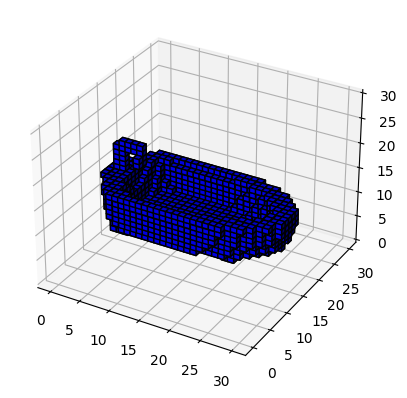

The predicted class for the model is: bathtub


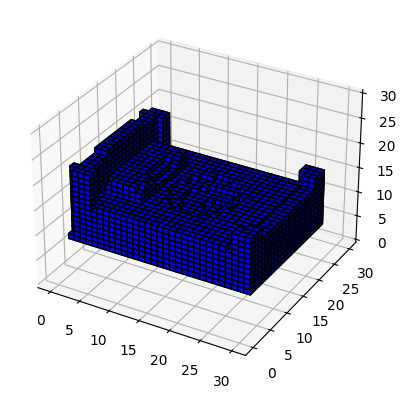

The predicted class for the model is: bed


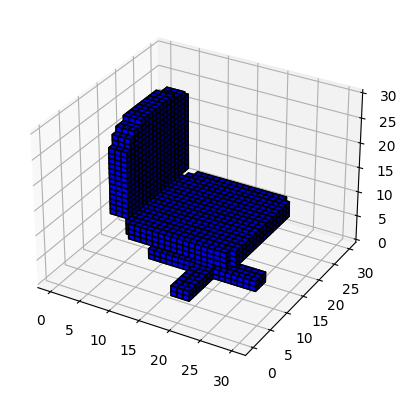

The predicted class for the model is: chair


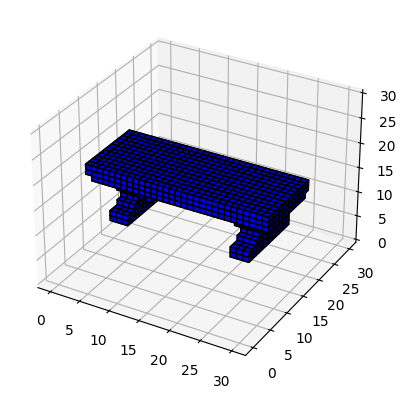

The predicted class for the model is: table


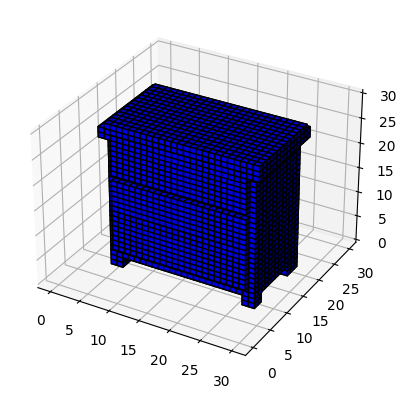

The predicted class for the model is: dresser


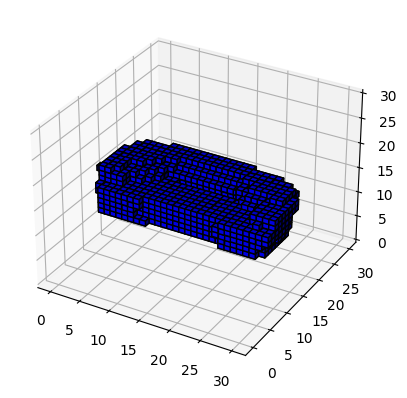

The predicted class for the model is: sofa


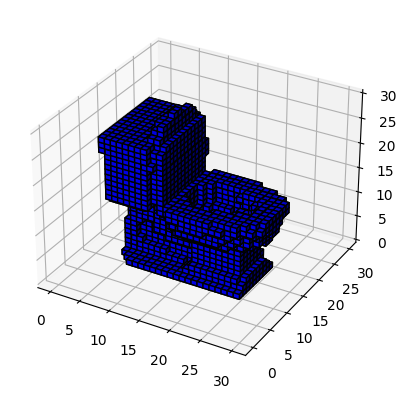

The predicted class for the model is: toilet


In [ ]:
# Correct the preprocess_new_data to accept VoxelModel instances
def preprocess_new_data(voxel_model):
    # Convert the matrix to a numpy array and add batch and channel dimensions
    new_voxel = np.expand_dims(np.array(voxel_model.mat), axis=(0, -1)).astype('float32')
    return new_voxel

def extract_features(model, voxels):
    features = model.encode(voxels).numpy()
    return features

# List of class names in the order corresponding to the class indices
class_names = ['bathtub', 'bed', 'chair', 'desk', 'dresser',
               'monitor', 'night_stand', 'sofa', 'table', 'toilet']

# Assuming `models3d` is a list of 3D model data ready to be processed
for model3d_voxelized in models3d_voxelized:
    model3d_voxelized.show_3d() # View model
    voxelized_model3d = preprocess_new_data(model3d_voxelized)
    features = extract_features(loaded_autoencoder_model, voxelized_model3d)
    # Flatten the features to remove the batch dimension
    features_flat = features.reshape(1, -1)
    predicted_class_index = loaded_svm_classifier.predict(features_flat)
    predicted_class_name = class_names[predicted_class_index[0] - 1]  # Map index to name
    print(f"The predicted class for the model is: {predicted_class_name}")